<a href="https://colab.research.google.com/github/Ahella-Bassem-Mohammed/Stroke_Pre-Detection_Analysis/blob/main/Stroke_Project_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc,log_loss,precision_recall_curve, average_precision_score



import joblib

In [29]:
# ========== 1. Load Data ==========
df = pd.read_csv("/content/cleaned_stroke_data2.csv")


# ========== 3. Split Features and Target ==========
X = df.drop("stroke", axis=1)
y = df["stroke"]

# ========== 4. Train/Test Split ==========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [31]:
# ========== 6. Train Gradient Boosting Model ==========
gb_model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.1,
    min_samples_split=5,
    min_samples_leaf=5,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

gb_model.fit(X_train, y_train)

# ========== 7. Predict and Evaluate ==========
y_pred = gb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("✅ Accuracy:", accuracy)
print("🎯 F1-Score:", f1)
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔍 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

✅ Accuracy: 0.9583333333333334
🎯 F1-Score: 0.9578344612181156

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       972
           1       0.97      0.95      0.96       972

    accuracy                           0.96      1944
   macro avg       0.96      0.96      0.96      1944
weighted avg       0.96      0.96      0.96      1944


🔍 Confusion Matrix:
 [[943  29]
 [ 52 920]]


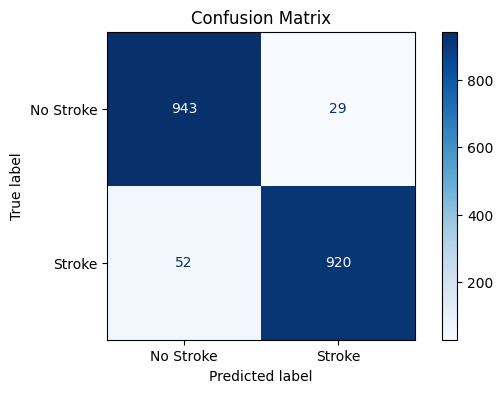

In [32]:

ConfusionMatrixDisplay.from_estimator(
    gb_model, X_test, y_test,
    display_labels=["No Stroke", "Stroke"],
    cmap=plt.cm.Blues,
    values_format='d'
)
plt.title("Confusion Matrix")
plt.show()

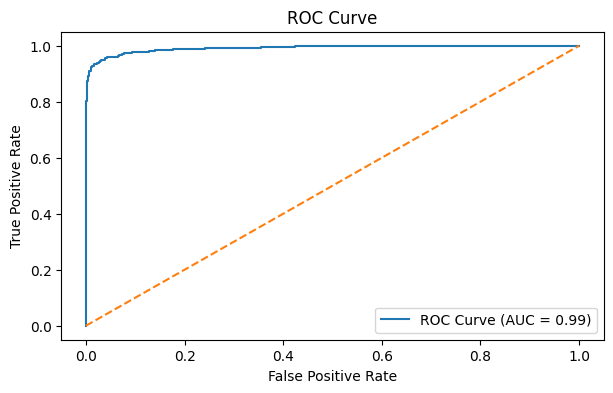

In [33]:

fpr, tpr, _ = roc_curve(y_test, gb_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()


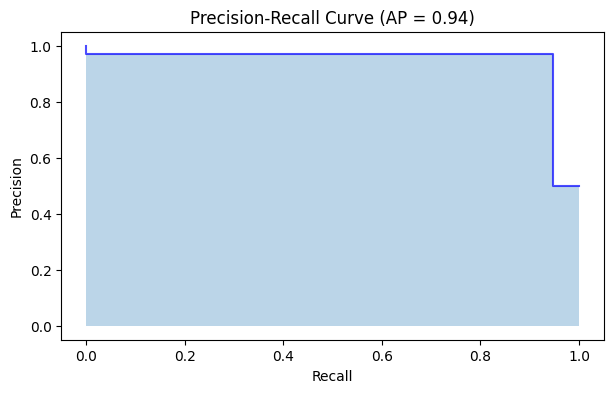

In [34]:


precision, recall, _ = precision_recall_curve(y_test, y_pred)
avg_precision = average_precision_score(y_test, y_pred)

plt.step(recall, precision, where='post', color='b', alpha=0.7)
plt.fill_between(recall, precision, step='post', alpha=0.3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP = {avg_precision:.2f})")
plt.show()

<ipython-input-36-d6395633ee19>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importance, y=feat_importance.index, palette="viridis")


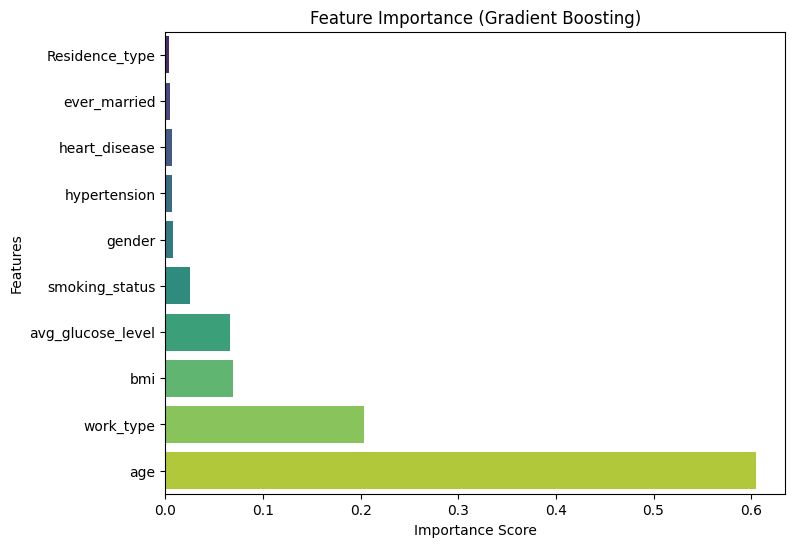

In [36]:
feat_importance = pd.Series(gb_model.feature_importances_, index=X.columns)
feat_importance = feat_importance.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
sns.barplot(x=feat_importance, y=feat_importance.index, palette="viridis")
plt.title("Feature Importance (Gradient Boosting)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

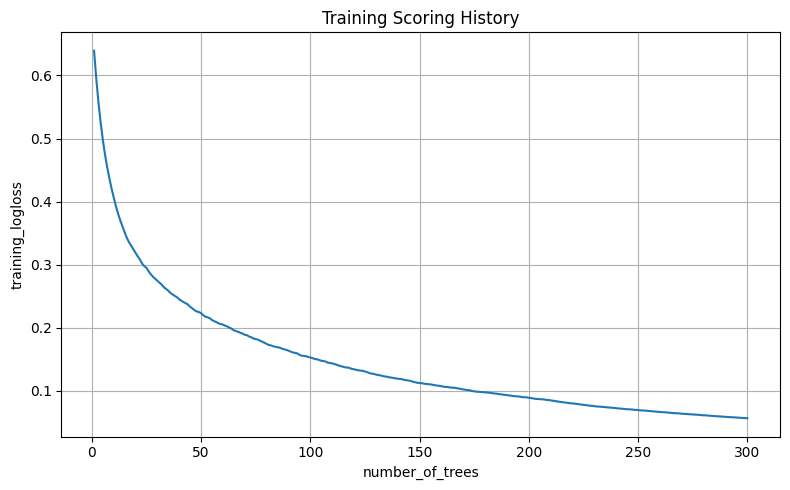

In [37]:


# Store log loss at each stage
log_losses = []
n_estimators = gb_model.n_estimators

for y_proba in gb_model.staged_predict_proba(X_train):
    loss = log_loss(y_train, y_proba)
    log_losses.append(loss)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_estimators + 1), log_losses, label='Training Log Loss')
plt.xlabel("number_of_trees")
plt.ylabel("training_logloss")
plt.title("Training Scoring History")
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
# Step 7: Save the Best Model and Scaler
# ===========================


joblib.dump(gb_model, 'stroke_model.pkl')


print("\n✅ Model Saved Successfully!")


✅ Model Saved Successfully!
